In [1]:
from typing import Union, Optional, Callable, Any
from typing import Tuple, List, Set, Dict
from typing import NamedTuple

In [2]:
from collections import defaultdict, deque

In [3]:
import os
import sys
import time
import datetime
import random
import math
import itertools
import uuid

In [4]:
import multiprocess

In [5]:
import numpy as np
import pandas as pd
from PIL import Image, ImageChops

In [6]:
import plotly.express as px
import matplotlib.pyplot as plt

In [7]:
import os
import sys
from contextlib import contextmanager

@contextmanager
def stdout_redirected(to=os.devnull):
    '''
    import os

    with stdout_redirected(to=filename):
        print("from Python")
        os.system("echo non-Python applications are also supported")
    '''
    fd = sys.stdout.fileno()

    ##### assert that Python and C stdio write using the same file descriptor
    ####assert libc.fileno(ctypes.c_void_p.in_dll(libc, "stdout")) == fd == 1

    def _redirect_stdout(to):
        #sys.stdout.close() # + implicit flush()
        os.dup2(to.fileno(), fd) # fd writes to 'to' file
        sys.stdout = os.fdopen(fd, 'w') # Python writes to fd

    with os.fdopen(os.dup(fd), 'w') as old_stdout:
        with open(to, 'w') as file:
            _redirect_stdout(to=file)
        try:
            yield # allow code to be run with the redirected stdout
        finally:
            _redirect_stdout(to=old_stdout) # restore stdout.
                                            # buffering and flags such as
                                            # CLOEXEC may be different

In [8]:
devnull = open(os.devnull, 'w')
oldstdout_fno = os.dup(sys.stdout.fileno())
os.dup2(devnull.fileno(), 1)
import getfem as gf
os.dup2(oldstdout_fno, 1)
devnull.close()

In [9]:
import getfem as gf

In [10]:
import pyvista as pv
from pyvirtualdisplay.display import Display

In [11]:
import torch
from torch import nn

from torch.nn.modules.loss import _Loss
from torch.optim import Optimizer

print(torch.__version__)

1.10.0


In [12]:
cuda = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Current computing device:', cuda)

Current computing device: cuda


In [13]:
#
# Physical parameters
#
epsilon = .02       # Thickness of the plate (cm)
E = 21E6           # Young Modulus (N/cm^2)
nu = 0.3           # Poisson ratio
clambda = E*nu/((1+nu)*(1-2*nu)) # First Lame coefficient (N/cm^2)
cmu = E/(2*(1+nu))               # Second Lame coefficient (N/cm^2)
clambdastar = 2*clambda*cmu/(clambda+2*cmu) # Lame coefficient for Plane stress (N/cm^2)
F = 100E2          # Force density at the right boundary (N/cm^2)
kappa = 4.         # Thermal conductivity (W/(cm K))
D = 10.            # Heat transfer coefficient (W/(K cm^2))
air_temp = 20.     # Temperature of the air in oC.
alpha_th = 16.6E-6 # Thermal expansion coefficient (/K).
T0 = 20.           # Reference temperature in oC.
rho_0 = 1.754E-8   # Resistance temperature coefficient at T0 = 20oC
alpha = 0.0039     # Second resistance temperature coefficient.

In [14]:
#
# Numerical parameters
#
h = 2.                    # Approximate mesh size
elements_degree = 2       # Degree of the finite element methods
export_mesh = True        # Draw the mesh after mesh generation or not
solve_in_two_steps = 1    # Solve the elasticity problem separately (1)
                          # or in a coupled way (0) or both and compare (2)

In [15]:
# Data Classes
State = torch.Tensor
    
Action = Tuple[Tuple[int, int], float] 

class Transition(NamedTuple):
    state: State
    action: Action
    reward: float
    next_state: State

In [16]:
class GridHoleBoardEnv():
    def __init__(self, 
                 size: Tuple[float, float], 
                 grid_size: Tuple[int, int],
                 holes_disabled: Optional[Set[Tuple[int, int]]] = None) -> None:
        self.size: Tuple[float, float] = size
        self.grid_size: Tuple[int, int] = grid_size
        self.cell_size: Tuple[float, float] = (size[0] / grid_size[0], size[1] / grid_size[1])
        # (x, y) -> size
        self.holes: torch.Tensor = torch.zeros(self.grid_size, device=cuda)
            
        # (x, y) -> (x_coord, y_coord)
        self.holes_center: torch.Tensor = torch.zeros((*self.grid_size, 2))
            
        self.holes_disabled: Set[Tuple(int, int)] = holes_disabled if holes_disabled else {}
            
        self.action_space: List[Tuple[Tuple[int, int], float]] = list()
            
        for x in range(self.grid_size[0]):
            for y in range(self.grid_size[1]):
                self.holes_center[x, y, 0] = (x + 0.5) * self.cell_size[0]
                self.holes_center[x, y, 1] = (y + 0.5) * self.cell_size[1]
                if (x, y) not in self.holes_disabled:
                    self.action_space.append(((x, y), 0.5))
                    self.action_space.append(((x, y), -0.5))
                    
    def reset(self) -> None:
        self.holes: torch.Tensor = torch.ones(self.grid_size, device=cuda)
            
    def random(self) -> None:
        self.holes: torch.Tensor = torch.rand(self.grid_size, device=cuda) * 3
    
    def step(self, action: Action) -> None:
        (x, y), size_change = action
        
        self.holes[x, y] += size_change
        
        self.holes[x, y] = torch.clamp(self.holes[x, y], 0., min(self.cell_size) / 2 - 1)
        
    def get_current_state(self) -> State:
        return self.holes.clone()

In [17]:
class GridHoleBoardThermalSimulator():
    def __init__(self, element_diameter: float = 2) -> None:
        self.element_diameter: float = element_diameter
        self.mesh: gf.Mesh = None
        
    
    def generate_fem_mesh(self, 
                          hole_board_env: GridHoleBoardEnv, 
                          state: Optional[torch.Tensor] = None, 
                          export_mesh: bool = False) -> gf.Mesh:
        board = gf.MesherObject('rectangle', [0., 0.], list(hole_board_env.size))
        holes: List[gf.MesherObject] = list()
        
        for x in range(hole_board_env.grid_size[0]):
            for y in range(hole_board_env.grid_size[1]):
                center = hole_board_env.holes_center[x, y].tolist()
                if state:
                    size = state[x, y].item()
                else:
                    size = hole_board_env.holes[x, y].item()

                if size < 0.01 * self.element_diameter: continue
                
                holes.append(gf.MesherObject('ball', center, size))
            
        if holes:
            holes_union = gf.MesherObject('union', *holes)
            mesher = gf.MesherObject('set minus', board, holes_union)
        else:
            mesher = board
        
        print('Beginning mesh generation')
        gf.util('trace level', 2)   # No trace for mesh generation
        mesh = gf.Mesh('generate', mesher, self.element_diameter, 2)
        
        boundary: Dict[str, int] = dict()
            
        # Boundary of the holes
        boundary['HOLE_BOUND'] = 1
        mesh.set_region(boundary['HOLE_BOUND'], 
                        mesh.outer_faces_in_box([1., 1.], 
                                                [hole_board_env.size[0] - 1, hole_board_env.size[1] - 1]))
        
        boundary['LEFT_BOUND'] = 2
        mesh.set_region(boundary['LEFT_BOUND'], mesh.outer_faces_with_direction([-1., 0.], 0.01))        
        
        boundary['RIGHT_BOUND'] = 3
        mesh.set_region(boundary['RIGHT_BOUND'], mesh.outer_faces_with_direction([ 1., 0.], 0.01)) 
        
        boundary['TOP_BOUND'] = 4
        mesh.set_region(boundary['TOP_BOUND'], mesh.outer_faces_with_direction([0.,  1.], 0.01)) 
        
        boundary['BOTTOM_BOUND'] = 5
        mesh.set_region(boundary['BOTTOM_BOUND'], mesh.outer_faces_with_direction([0., -1.], 0.01)) 
        
        mesh.region_subtract( boundary['RIGHT_BOUND'], boundary['HOLE_BOUND'])
        mesh.region_subtract(  boundary['LEFT_BOUND'], boundary['HOLE_BOUND'])
        mesh.region_subtract(   boundary['TOP_BOUND'], boundary['HOLE_BOUND'])
        mesh.region_subtract(boundary['BOTTOM_BOUND'], boundary['HOLE_BOUND'])
                
        region_id = 7
        for x in range(hole_board_env.grid_size[0]):
            for y in range(hole_board_env.grid_size[1]):
                center = hole_board_env.holes_center[x, y].tolist()
                if state:
                    size = state[x, y].item()
                else:
                    size = hole_board_env.holes[x, y].item()
                bound_key = f'HOLE{x}_{y}_BOUND'
                boundary[bound_key] = region_id
                mesh.set_region(boundary[bound_key], 
                                mesh.outer_faces_in_ball(center, size + 0.01 * self.element_diameter))
                if region_id == 7:
                    boundary['HOLE_UNION_BOUND'] = 6
                    mesh.set_region(boundary['HOLE_UNION_BOUND'], 
                                mesh.outer_faces_in_ball(center, size + 0.01 * self.element_diameter))
                else:
                    mesh.region_merge(boundary['HOLE_UNION_BOUND'], boundary[bound_key])
                region_id += 1
            
        np.testing.assert_array_equal(mesh.region(boundary['HOLE_BOUND']), 
                                      mesh.region(boundary['HOLE_UNION_BOUND']))
        
        self.mesh = mesh
        
        if (export_mesh):
            m = mesh.export_to_vtk('temp.vtk');
            print('\nMesh generation completed.');
                        
        return mesh, boundary
        
    
    def run(self) -> Any:
        # Load the T1, T2 temperature
        # Set T1 to left bound, T2 to right
        # Run fem for self.mesh
        # Save the result to temp.vtk
        ...
    
    def render_image(self, save_file: Optional[str] = None) -> Any:
        display = Display(visible=0, size=(1280, 1024))
        display.start()
        p = pv.Plotter()
        m = pv.read("temp.vtk")
        p.add_mesh(m, show_edges=True)
#         if p.scalar_bars:
#             for sb in list(p.scalar_bars.keys()):
#                 p.remove_scalar_bar(sb)
        p.camera_position = 'xy'
        img_arr = p.screenshot(save_file, transparent_background=True)
        display.stop()
        return img_arr

In [18]:
def run_fem(mesh, boundary):
    #
    # Definition of finite elements methods and integration method
    #

    mfu = gf.MeshFem(mesh, 2)  # Finite element for the elastic displacement
    mfu.set_classical_fem(elements_degree)
    mft = gf.MeshFem(mesh, 1)  # Finite element for temperature and electrical field
    mft.set_classical_fem(elements_degree)
    mfvm = gf.MeshFem(mesh, 1) # Finite element for Von Mises stress interpolation
    mfvm.set_classical_discontinuous_fem(elements_degree)
    mim = gf.MeshIm(mesh, elements_degree*2)   # Integration method

    md=gf.Model('real');
    md.add_fem_variable('u', mfu)       # Displacement of the structure
    md.add_fem_variable('theta', mft)   # Temperature
    md.add_fem_variable('V', mft)       # Electric potential

    # Membrane elastic deformation
    md.add_initialized_data('cmu', [cmu])
    md.add_initialized_data('clambdastar', [clambdastar])
    md.add_isotropic_linearized_elasticity_brick(mim, 'u', 'clambdastar', 'cmu')

    md.add_Dirichlet_condition_with_multipliers(mim, 'u', elements_degree-1, boundary['LEFT_BOUND'])
    md.add_initialized_data('Fdata', [F*epsilon, 0])
    md.add_source_term_brick(mim, 'u', 'Fdata', boundary['RIGHT_BOUND'])

    # Electrical field
    sigmaeps = '(eps/(rho_0*(1+alpha*(theta-T0))))'
    md.add_initialized_data('eps', [epsilon])
    md.add_initialized_data('rho_0', [rho_0])
    md.add_initialized_data('alpha', [alpha])
    md.add_initialized_data('T0', [T0])
    md.add_nonlinear_term(mim, sigmaeps+'*(Grad_V.Grad_Test_V)')
    md.add_Dirichlet_condition_with_multipliers(mim, 'V', elements_degree-1, boundary['RIGHT_BOUND'])
    md.add_initialized_data('DdataV', [2.])
    md.add_Dirichlet_condition_with_multipliers(mim, 'V', elements_degree-1, boundary['LEFT_BOUND'], 'DdataV')

    # Thermal problem
    md.add_initialized_data('kaeps', [kappa*epsilon])
    md.add_generic_elliptic_brick(mim, 'theta', 'kaeps')
    md.add_initialized_data('D2', [D*2])
    md.add_initialized_data('D2airt', [air_temp*D*2])
    md.add_mass_brick(mim, 'theta', 'D2')
    md.add_source_term_brick(mim, 'theta', 'D2airt')
    md.add_initialized_data('Deps', [D/epsilon])
    md.add_initialized_data('Depsairt', [air_temp*D/epsilon])
    md.add_Fourier_Robin_brick(mim, 'theta', 'Deps', boundary['TOP_BOUND'])
    md.add_source_term_brick(mim, 'theta', 'Depsairt', boundary['TOP_BOUND'])
    md.add_Fourier_Robin_brick(mim, 'theta', 'Deps', boundary['BOTTOM_BOUND'])
    md.add_source_term_brick(mim, 'theta', 'Depsairt', boundary['BOTTOM_BOUND'])

    # Joule heating term
    md.add_nonlinear_term(mim, '-'+sigmaeps+'*Norm_sqr(Grad_V)*Test_theta')

    # Thermal expansion term
    md.add_initialized_data('beta', [alpha_th*E/(1-2*nu)])
    md.add_linear_term(mim, 'beta*(T0-theta)*Trace(Grad_Test_u)')

    #
    # Model solve
    #

    md.disable_variable('u')
    md.solve('max_res', 1E-9, 'max_iter', 100)

    #
    # Solution export
    #  
    U = md.variable('u')
    V = md.variable('V')
    THETA = md.variable('theta')
    VM = md.compute_isotropic_linearized_Von_Mises_or_Tresca('u', 'clambdastar', 'cmu', mfvm)
    CO = np.reshape(md.interpolation('-'+sigmaeps+'*Grad_V', mfvm), (2, mfvm.nbdof()), 'F')

#     mfvm.export_to_vtk('displacement_with_von_mises.vtk', mfvm,  VM, 'Von Mises Stresses', mfu, U, 'Displacements')
#     print('You can view solutions with for instance:\nmayavi2 -d displacement_with_von_mises.vtk -f WarpVector -m Surface')
    filename = f'temp/{uuid.uuid4()}.vtk'
    mft.export_to_vtk(filename, mft, THETA, 'Temperature')
    return filename
#     print('mayavi2 -d temperature.vtk -f WarpScalar -m Surface')
#     mft.export_to_vtk('electric_potential.vtk', mft, V, 'Electric potential')
#     print('mayavi2 -d electric_potential.vtk -f WarpScalar -m Surface')


In [19]:
multiprocess.set_start_method('spawn')

In [20]:
def render_image(filename):
    import pyvista as pv
    from pyvirtualdisplay.display import Display
    display = Display(visible=0, size=(1280, 1024))
    display.start()
    p = pv.Plotter()
    m = pv.read(filename)
    p.enable_3_lights()
    p.add_mesh(m, line_width=5, cmap='Greys_r', clim=[20, 60]) #
    if p.scalar_bars:
        for sb in list(p.scalar_bars.keys()):
            p.remove_scalar_bar(sb)
    p.view_xy()
#     p.show(window_size=[512, 384], jupyter_backend='panel', cpos="xy")
    img = p.screenshot(filename=None, transparent_background=True, window_size=[512, 384])
    display.stop()
    return img

In [21]:
# pool = multiprocess.Pool(32)
# result = pool.map(render_image, ['feme.vtk']*100)

In [22]:
q = multiprocess.Queue()

In [23]:
q.__dir__()

['_maxsize',
 '_reader',
 '_writer',
 '_rlock',
 '_opid',
 '_wlock',
 '_sem',
 '_ignore_epipe',
 '_notempty',
 '_buffer',
 '_thread',
 '_jointhread',
 '_joincancelled',
 '_closed',
 '_close',
 '_send_bytes',
 '_recv_bytes',
 '_poll',
 '__module__',
 '__init__',
 '__getstate__',
 '__setstate__',
 '_after_fork',
 'put',
 'get',
 'qsize',
 'empty',
 'full',
 'get_nowait',
 'put_nowait',
 'close',
 'join_thread',
 'cancel_join_thread',
 '_start_thread',
 '_finalize_join',
 '_finalize_close',
 '_feed',
 '_on_queue_feeder_error',
 '__dict__',
 '__weakref__',
 '__doc__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__new__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

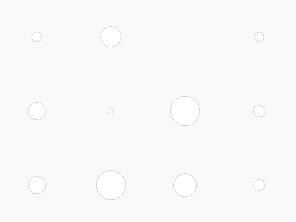

In [24]:
filename = 'temp.vtk'
import pyvista as pv
from pyvirtualdisplay.display import Display
with Display(visible=0, size=(1280, 1024)) as display:
    p = pv.Plotter(off_screen=True, lighting='three lights')
    p.enable_3_lights()
    if p.scalar_bars:
        for sb in list(p.scalar_bars.keys()):
            p.remove_scalar_bar(sb)



    m = pv.read(filename)

    a = p.add_mesh(m, line_width=5, cmap='Greys_r', clim=[20, 60], show_scalar_bar=False)
    p.view_xy()

    img_arr = p.screenshot(filename=f'temp.png', transparent_background=True, window_size=[512, 384])

    #p.remove_actor(a, render=False)

    img = Image.fromarray(img_arr)
    bg = Image.new(img.mode, img.size, img.getpixel((0,0)))
    diff = ImageChops.difference(img, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        img = img.crop(bbox)
    img_tensor = torch.tensor(np.array(img))
img

In [25]:
type(torch.device('cuda'))

torch.device

In [26]:
def trim_image(img: Image):
    bg = Image.new(img.mode, img.size, img.getpixel((0,0)))
    diff = ImageChops.difference(img, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return img.crop(bbox)

Beginning mesh generation


Trace 2 in getfem_models.cc, line 4386: Mass term assembly for Dirichlet condition
Trace 2 in getfem_models.cc, line 4386: Mass term assembly for Dirichlet condition
Trace 2 in getfem_models.cc, line 4386: Mass term assembly for Dirichlet condition
Trace 2 in getfem_models.cc, line 4423: Source term assembly for Dirichlet condition
Trace 2 in getfem_models.cc, line 4386: Mass term assembly for Dirichlet condition
Trace 2 in getfem_models.cc, line 4386: Mass term assembly for Dirichlet condition
Trace 2 in getfem_models.cc, line 4423: Source term assembly for Dirichlet condition
Trace 2 in getfem_models.cc, line 3463: Generic elliptic: generic matrix assembly
Trace 2 in getfem_models.cc, line 3463: Mass matrix: generic matrix assembly
Trace 2 in getfem_models.cc, line 3299: Generic source term assembly
Trace 2 in getfem_models.cc, line 3306: Source term: generic source term assembly
Trace 2 in getfem_models.cc, line 3463: Fourier-Robin: generic matrix assembly
Trace 2 in getfem_models.c

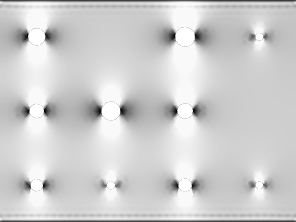

In [27]:
env = GridHoleBoardEnv(size=(80, 60), grid_size=(4, 3))
env.random()

fem = GridHoleBoardThermalSimulator(element_diameter=2)
mesh, boundary = fem.generate_fem_mesh(env, export_mesh=False)
result = run_fem(mesh, boundary)
img = trim_image(Image.fromarray(render_image(result)))
img

In [28]:
pv.read(result)

UnstructuredGrid (0x15215058c0a0)
  N Cells:	2583
  N Points:	5362
  X Bounds:	0.000e+00, 8.000e+01
  Y Bounds:	0.000e+00, 6.000e+01
  Z Bounds:	0.000e+00, 0.000e+00
  N Arrays:	1

In [29]:
result = torch.tensor(np.array(img))
result.size()

torch.Size([222, 296, 4])

In [30]:
result

tensor([[[ 81,  81,  81, 255],
         [ 81,  81,  81, 255],
         [ 74,  74,  74, 255],
         ...,
         [ 64,  64,  64, 255],
         [ 73,  73,  73, 255],
         [ 73,  73,  73, 255]],

        [[171, 171, 171, 255],
         [164, 164, 164, 255],
         [143, 143, 143, 255],
         ...,
         [126, 126, 126, 255],
         [147, 147, 147, 255],
         [152, 152, 152, 255]],

        [[237, 237, 237, 255],
         [226, 226, 226, 255],
         [216, 216, 216, 255],
         ...,
         [192, 192, 192, 255],
         [207, 207, 207, 255],
         [220, 220, 220, 255]],

        ...,

        [[234, 234, 234, 255],
         [221, 221, 221, 255],
         [208, 208, 208, 255],
         ...,
         [196, 196, 196, 255],
         [211, 211, 211, 255],
         [224, 224, 224, 255]],

        [[169, 169, 169, 255],
         [163, 163, 163, 255],
         [140, 140, 140, 255],
         ...,
         [130, 130, 130, 255],
         [151, 151, 151, 255],
         

In [31]:
from torchvision.transforms import PILToTensor

In [32]:
ttresult = PILToTensor()(img)
ttresult.size()

torch.Size([4, 222, 296])

In [33]:
ttresult[0]

tensor([[ 81,  81,  74,  ...,  64,  73,  73],
        [171, 164, 143,  ..., 126, 147, 152],
        [237, 226, 216,  ..., 192, 207, 220],
        ...,
        [234, 221, 208,  ..., 196, 211, 224],
        [169, 163, 140,  ..., 130, 151, 157],
        [ 81,  81,  71,  ...,  66,  74,  74]], dtype=torch.uint8)

In [34]:
torch.BoolTensor(*(ttresult[0].size()))
for spot in compare_spot:
    compare_mask[spot] = True

NameError: name 'compare_spot' is not defined

In [ ]:
target_img = Image.open('target.png')
target_img

In [ ]:
result = ToTensor()(img)[0]
result.size()

In [ ]:
target = ToTensor()(target_img)[0]

In [ ]:
target.size()

In [ ]:
compare_spot = [(73, 36),
               (147, 36),
               (73, 110),
               (147, 110),
               (73, 184),
               (147, 184),
               (73, 258),
               (147, 258)]
compare_mask = torch.BoolTensor(*target.size()).fill_(False)
for spot in compare_spot:
    compare_mask[spot] = True

pool_radius = 2


In [ ]:
compare_mask.size()

In [ ]:
r = result[compare_mask]
r

In [ ]:
t = target[compare_mask].reshape((8, 4))[:, 1].to(torch.float)
t

In [ ]:
import matplotlib.cm as cm
g = cm.get_cmap('Greys_r')
g(254)

In [ ]:
r - t

In [ ]:
t

In [ ]:
setattr(type(t), 'mp_manager', 123)

In [ ]:
getattr(type(t), 'mp_manager')